In [1]:
# Upgrade transformers to satisfy kaggle-environments
!pip install --upgrade transformers

# Downgrade torch and install compatible torchvision
!pip install torch==2.0.1 torchvision==0.15.2

# Resolve ydata-profiling conflicts
!pip install scipy==1.10.1
!pip install --upgrade typeguard
# Alternatively, upgrade ydata-profiling
# !pip install --upgrade ydata-profiling

# Install other required packages
!pip install unidecode tensorflow-addons datasets

# Restart the kernel after installations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 74.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 72.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 84.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 74.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Install necessary packages

# Import libraries
import torch
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertModel, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
from datasets import Dataset
device = torch.device("cuda") 

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7


# BERT Model
## 1) Import Necessary Dependencies and use GPU

In [3]:
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define text cleaning functions
def remove_non_alphanum(string):
    if isinstance(string, str):
        string = unidecode(string)
        string = re.sub(r'[^a-zA-Z0-9\s]', '', string)
    return string

def lowercase_and_remove_stopwords(string):
    words = string.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Load the data
train = pd.read_csv('/kaggle/input/movie-plots/train.txt', 
                    delimiter='\t', 
                    names=["Title", "Industry", "Genre", "Director", "Plot"])
test = pd.read_csv('/kaggle/input/movie-plots/test_no_labels.txt', 
                   delimiter='\t', 
                   names=["Title", "Industry", "Director", "Plot"])

# Clean the 'Plot' and 'Director' columns
for df in [train, test]:
    df['Plot'] = df['Plot'].apply(remove_non_alphanum).apply(lowercase_and_remove_stopwords)
    df['Director'] = df['Director'].apply(remove_non_alphanum).apply(lowercase_and_remove_stopwords)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3) Check Class Imbalance

In [4]:
# Check for class imbalance
genre_counts = train['Genre'].value_counts()
print("Genre counts in training data:")
print(genre_counts)

Genre counts in training data:
Genre
drama        1676
comedy       1193
horror       1108
action       1059
romance       886
western       829
crime         541
animation     535
sci-fi        214
Name: count, dtype: int64


## 4) Prepare Data

### a. Split Data into Training, Validation and Test Subsets

In [5]:
def split_data(data):
    # Use only the first 100 samples for faster execution
    train_data, tmp_data = train_test_split(
        data, 
        test_size=0.2, 
        shuffle=True,
        random_state=42
    )

    validation_data, test_data = train_test_split(
        tmp_data, 
        test_size=0.5, 
        shuffle=True,
        random_state=42
    )
    return train_data, validation_data, test_data

train_data, val_data, test_data = split_data(train)

### b. Encode Labels and Directors

In [6]:
# Encode genres
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['Genre'])
val_data['label'] = label_encoder.transform(val_data['Genre'])
test_data['label'] = label_encoder.transform(test_data['Genre'])

## 5) Tokenization

In [7]:
# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer.add_special_tokens({'additional_special_tokens': ['[DIRECTOR]']})

# Function to tokenize data
def tokenize_function(examples):
    director_names = [f"[DIRECTOR] {director}" for director in examples['Director']]
    texts_with_directors = [f"{director_name} {text}" for director_name, text in zip(director_names, examples['Plot'])]
    return tokenizer(texts_with_directors, padding='max_length', truncation=True, max_length=512)

# Prepare the datasets for Hugging Face
train_dataset = Dataset.from_pandas(train_data[['Plot', 'Director', 'label']])
val_dataset = Dataset.from_pandas(val_data[['Plot', 'Director', 'label']])
test_dataset = Dataset.from_pandas(test_data[['Plot', 'Director', 'label']])

# Apply the tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/6432 [00:00<?, ? examples/s]

Map:   0%|          | 0/804 [00:00<?, ? examples/s]

Map:   0%|          | 0/805 [00:00<?, ? examples/s]

## 6) Define the model

In [8]:
import torch.nn as nn

from transformers.modeling_outputs import SequenceClassifierOutput

class DistilBertForGenreClassification(nn.Module):
    def __init__(self, num_labels):
        super(DistilBertForGenreClassification, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(self.bert.config.hidden_size, num_labels)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        # Get BERT output
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.last_hidden_state[:, 0, :]  # [CLS] token output
        # Get logits from classifier
        logits = self.classifier(pooled_output)
        
        if labels is not None:
            # Compute loss
            loss = self.loss_fn(logits, labels)
            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=bert_outputs.hidden_states,
                attentions=bert_outputs.attentions,
            )
        else:
            # Return logits only
            return SequenceClassifierOutput(
                logits=logits,
                hidden_states=bert_outputs.hidden_states,
                attentions=bert_outputs.attentions,
            )


## 7) Instantiate and Train the Model

In [9]:
# Instantiate the model
num_labels = len(label_encoder.classes_)
model = DistilBertForGenreClassification(num_labels=num_labels)
model.bert.resize_token_embeddings(len(tokenizer))
# model = model.to(device)

# Check if the model's parameters are on the GPU
#for param in model.parameters():
    #print(param.device)
    
    
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    num_train_epochs=10,  # Reduced for faster execution
    # per_device_train_batch_size=4,  # Adjust batch size as needed
    # per_device_eval_batch_size=4,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to=[],
)

# Define compute_metrics function for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = (predictions == labels).mean()
    return {'accuracy': accuracy}

# Data collator
data_collator = DataCollatorWithPadding(tokenizer)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
trainer.train()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.970000,0.884559,0.686567
2,0.763700,0.822163,0.711443
3,0.414100,0.979264,0.705224
4,0.194300,1.321866,0.697761


TrainOutput(global_step=3216, training_loss=0.6206308505057696, metrics={'train_runtime': 759.4748, 'train_samples_per_second': 84.69, 'train_steps_per_second': 10.586, 'total_flos': 0.0, 'train_loss': 0.6206308505057696, 'epoch': 4.0})

## 8) Evaluate the Model on the Test Subset

In [10]:
# Evaluate the model's performance on the test data
metrics = trainer.evaluate(test_dataset)
print(metrics)


{'eval_loss': 0.8119084239006042, 'eval_accuracy': 0.7403726708074534, 'eval_runtime': 7.3266, 'eval_samples_per_second': 109.874, 'eval_steps_per_second': 13.785, 'epoch': 4.0}


## 9) Make Predictions on the Test Subset, Calculate Metrics and Plot Confusion Matrix

Classification Report with Accuracy per Genre:

           precision  recall  f1-score  support
action        0.6610  0.7573    0.7059      103
animation     0.9362  0.8000    0.8627       55
comedy        0.7439  0.5648    0.6421      108
crime         0.6471  0.6600    0.6535       50
drama         0.6500  0.6964    0.6724      168
horror        0.8450  0.9083    0.8755      120
romance       0.6818  0.5294    0.5960       85
sci-fi        0.5417  0.7222    0.6190       18
western       0.8889  0.9796    0.9320       98


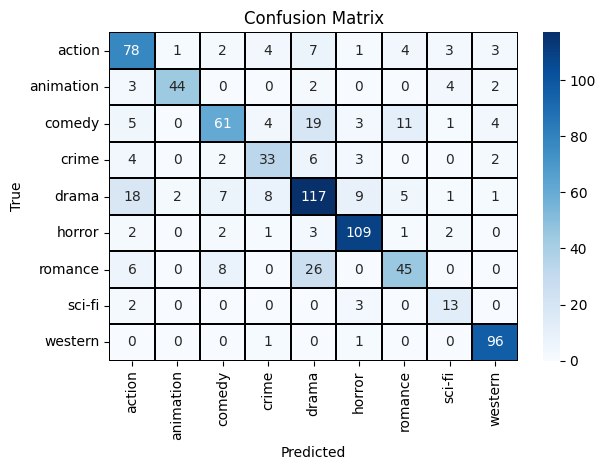

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Obtain predictions from the model
predictions_output = trainer.predict(test_dataset)
predictions = predictions_output.predictions

# Step 2: Interpret predictions
predicted_class_indices = np.argmax(predictions, axis=1)
predicted_classes = label_encoder.inverse_transform(predicted_class_indices)

# True labels
true_class_indices = test_dataset['label']
true_classes = label_encoder.inverse_transform(true_class_indices)

cm = confusion_matrix(true_classes, predicted_classes, labels=label_encoder.classes_)

def plot_confusion_matrix(y_true, y_pred, cm):
    # Display the confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.1, linecolor='black', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig("BERT_cm", bbox_inches='tight')

plot_confusion_matrix(y_true = true_classes, y_pred=predicted_classes, cm=cm)

# Initialize lists to hold metrics
precision_list = []
recall_list = []
f1_score_list = []
support_list = []
accuracy_list = []

total_samples = len(true_classes)

for i, genre in enumerate(label_encoder.classes_):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = total_samples - (TP + FP + FN)
    
    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    support = TP + FN  # Actual instances of the genre
    
    # Append metrics to lists
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1)
    # accuracy_list.append(accuracy)
    support_list.append(support)

# Create a DataFrame with the metrics
report_df = pd.DataFrame({
    'precision': precision_list,
    'recall': recall_list,
    'f1-score': f1_score_list,
    # 'accuracy': accuracy_list,
    'support': support_list
}, index=label_encoder.classes_)

# Round the metrics for better readability
report_df = report_df.round(4)

# Print the report
print("Classification Report with Accuracy per Genre:\n")
print(report_df)

## 10) Predict on the Unlabled Test Set

In [14]:
# Prepare the unlabeled test data
unlabeled_test = test.copy()  # Assuming 'test' is your test_no_labels.txt data

# Since we don't have labels, we can use the same process without labels
unlabeled_test_dataset = Dataset.from_pandas(unlabeled_test[['Plot', 'Director']])

# Tokenize the data
unlabeled_test_dataset = unlabeled_test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
unlabeled_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Get predictions
def test_sample_unlabeled(test_dataset, model):
    # Set model to evaluation mode
    model.eval()
    model.to(device)  # Move model to device
    
    # Use DataLoader for batching
    from torch.utils.data import DataLoader
    test_dataloader = DataLoader(test_dataset, batch_size=4)
    
    predictions = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)        # Move input_ids to device
            attention_mask = batch['attention_mask'].to(device)  # Move attention_mask to device
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            preds = torch.softmax(logits, dim=1)
            
            # Move predictions to CPU and convert to numpy
            predictions.extend(preds.cpu().numpy())
    return np.array(predictions)


unlabeled_predictions = test_sample_unlabeled(unlabeled_test_dataset, model)

# Decode predictions to labels
unlabeled_predicted_class_indices = np.argmax(unlabeled_predictions, axis=1)
unlabeled_predicted_classes = label_encoder.inverse_transform(unlabeled_predicted_class_indices)


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

## 11) Save the Results of the Final Predictions

In [15]:
# Write predictions to a text file
with open('results.txt', 'w') as f:
    for idx, pred_label in enumerate(unlabeled_predicted_classes):
        if idx < len(unlabeled_predicted_classes) - 1:
            f.write(f"{pred_label}\n")  # Add newline for all but the last element
        else:
            f.write(f"{pred_label}")  # Write last element without newline

# Extra Analysis/Tests
## 1) Testing with bait plots

In [16]:
# === Custom Testing with "Bait" Data ===

# 1. Create Custom Plots with Misleading Keywords
custom_plots = [
    {
        'Title': 'Laughing Shadows',
        'Director': 'John Doe',
        'Plot': "In a quiet town, a group of friends gathers for a fun night of laughter and games, but things take a terrifying turn when they discover a haunted board game that unleashes a hilarious yet deadly ghost."
    },
    {
        'Title': 'Funny Hauntings',
        'Director': 'Jane Smith',
        'Plot': "A family moves into a new house, hoping for a fresh start filled with joy and laughter. Strange, funny noises in the night lead them to a creepy basement where they encounter laughing dolls that bring their worst nightmares to life."
    },
    {
        'Title': 'Jokes of the Dead',
        'Director': 'Mike Johnson',
        'Plot': "An aspiring comedian visits an abandoned comedy club rumored to be haunted. Amidst the echoes of past laughs, he finds a joke book that brings him fame but at a horrifying cost."
    },
    {
        'Title': 'The Hilarious Curse',
        'Director': 'Emily Davis',
        'Plot': "During a comedy festival, a mysterious performer captivates audiences with dark humor that causes uncontrollable laughter, leading to bizarre and deadly consequences."
    },
    {
        'Title': 'Pranks Gone Wrong',
        'Director': 'Robert Brown',
        'Plot': "A group of teenagers decides to spend a funny weekend at a remote cabin. Their jokes and pranks awaken an ancient evil that twists their laughter into screams."
    }
]

# 2. Preprocess and Tokenize the Custom Plots
custom_data = pd.DataFrame(custom_plots)

# Clean the 'Plot' and 'Director' columns
custom_data['Plot'] = custom_data['Plot'].apply(remove_non_alphanum).apply(lowercase_and_remove_stopwords)
custom_data['Director'] = custom_data['Director'].apply(remove_non_alphanum).apply(lowercase_and_remove_stopwords)

# 3. Convert to Dataset and Set Format
custom_dataset = Dataset.from_pandas(custom_data[['Plot', 'Director']])

# Tokenize the data
custom_dataset = custom_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
custom_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# 4. Run Predictions on Custom Plots
# Ensure the model is on the correct device
model.to(device)

# Use the trainer's predict method
custom_predictions_output = trainer.predict(custom_dataset)
custom_predictions = custom_predictions_output.predictions

# Interpret predictions
custom_predicted_class_indices = np.argmax(custom_predictions, axis=1)
custom_predicted_genres = label_encoder.inverse_transform(custom_predicted_class_indices)

# Display the results
print("\n=== Custom Plot Predictions ===\n")
for idx, row in custom_data.iterrows():
    plot = row['Plot']
    title = row['Title']
    original_plot = custom_plots[idx]['Plot']  # Original plot before preprocessing
    predicted_genre = custom_predicted_genres[idx]
    print(f"Title: {title}")
    print("Plot:")
    print(original_plot)
    print(f"Predicted Genre: {predicted_genre}")
    print("-" * 80)


Map:   0%|          | 0/5 [00:00<?, ? examples/s]


=== Custom Plot Predictions ===

Title: Laughing Shadows
Plot:
In a quiet town, a group of friends gathers for a fun night of laughter and games, but things take a terrifying turn when they discover a haunted board game that unleashes a hilarious yet deadly ghost.
Predicted Genre: horror
--------------------------------------------------------------------------------
Title: Funny Hauntings
Plot:
A family moves into a new house, hoping for a fresh start filled with joy and laughter. Strange, funny noises in the night lead them to a creepy basement where they encounter laughing dolls that bring their worst nightmares to life.
Predicted Genre: horror
--------------------------------------------------------------------------------
Title: Jokes of the Dead
Plot:
An aspiring comedian visits an abandoned comedy club rumored to be haunted. Amidst the echoes of past laughs, he finds a joke book that brings him fame but at a horrifying cost.
Predicted Genre: comedy
-----------------------------

## 2) Genre misclassification analysis
### a. Analysis of Romance misclassificationn

Total 'romance' instances: 85
Misclassified 'romance' instances: 40

Genres predicted instead of 'romance':
drama: 26
comedy: 8
action: 6

Examples of misclassified 'romance' movies:
Title: Hum Ho Gaye Aapke
Director: agathiyan
Plot: rishi oberoi son oberoi family wealthy palatial home rishi womanizer often drinks one day comes across attractive young lady later comes know chandni gupta chandni impressed rishis advances ignores chandni employed organization love coworker mohan sachdev mohan chandni plan marry met opposition mohans parents result mohan marries someone else rishi comes know offers console chandni friend chandni decide would prefer womanizer former admirer friend
True Genre: romance
Predicted Genre: drama
--------------------------------------------------------------------------------
Title: Going Steady
Director: fred f sears
Plot: julie ann turner 17 wants travel car friends olive woody pasadena california home reno nevada boyfriend calvin potter participating basketbal

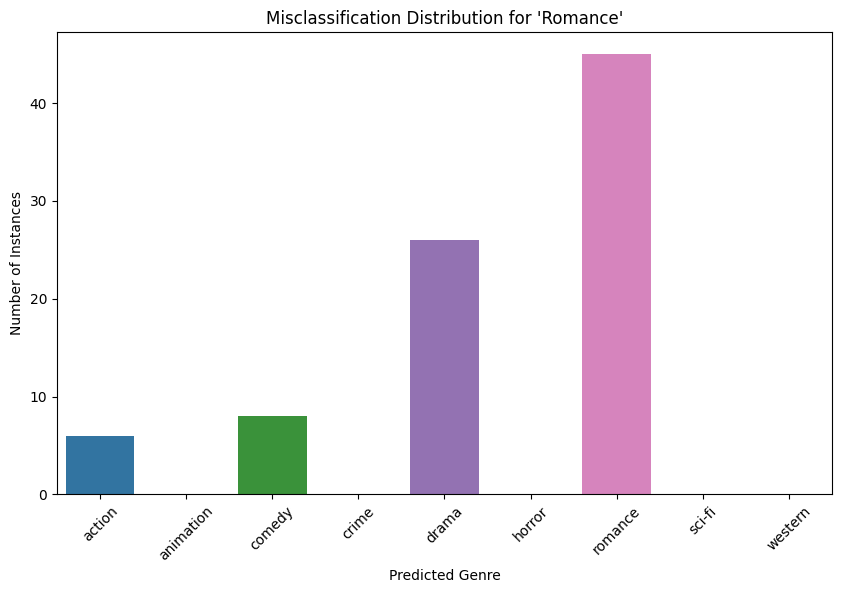

In [17]:
# === Analysis of Misclassified 'Romance' Instances ===

# Step 1: Extract Misclassified Instances for 'Romance'
# Get indices where true genre is 'romance'
romance_indices = np.where(true_classes == 'romance')[0]

# Among these, find indices where the prediction is not 'romance'
misclassified_indices = romance_indices[predicted_classes[romance_indices] != 'romance']

print(f"Total 'romance' instances: {len(romance_indices)}")
print(f"Misclassified 'romance' instances: {len(misclassified_indices)}")

# Step 2: Analyze the Distribution of Predicted Genres
# Get the predicted genres for the misclassified 'romance' instances
misclassified_predicted_genres = predicted_classes[misclassified_indices]

# Count the occurrences of each predicted genre
from collections import Counter

genre_counts = Counter(misclassified_predicted_genres)

print("\nGenres predicted instead of 'romance':")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

# Step 3: Display Misclassified Examples
# Get the misclassified examples from the test dataset
# Note: Ensure that 'test_data' is accessible here; if not, you may need to adjust the code
misclassified_data = test_data.reset_index(drop=True).iloc[misclassified_indices]

# Add the predicted genres to the DataFrame
misclassified_data = misclassified_data.copy()
misclassified_data['Predicted_Genre'] = predicted_classes[misclassified_indices]

# Display a few examples
print("\nExamples of misclassified 'romance' movies:")
for idx, row in misclassified_data.head(5).iterrows():
    print(f"Title: {row['Title']}")
    print(f"Director: {row['Director']}")
    print(f"Plot: {row['Plot']}")
    print(f"True Genre: {row['Genre']}")
    print(f"Predicted Genre: {row['Predicted_Genre']}")
    print("-" * 80)

# Step 4: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset confusion matrix for 'romance'
romance_row_index = list(label_encoder.classes_).index('romance')
cm_romance = cm[romance_row_index, :]

# Plot the misclassification distribution for 'romance'
plt.figure()
sns.barplot(x=label_encoder.classes_, y=cm_romance)
plt.title("Misclassification Distribution for 'Romance'")
plt.xlabel("Predicted Genre")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.savefig('/kaggle/working/misclassification_distribution_romance.png', bbox_inches='tight')
plt.show()


### b. Analysis of Comedy misclassificationon

Total 'comedy' instances: 108
Misclassified 'comedy' instances: 47

Genres predicted instead of 'comedy':
drama: 19
horror: 3
romance: 11
sci-fi: 1
action: 5
western: 4
crime: 4

Examples of misclassified 'comedy' movies:
Title: The Love Wager
Director: cyran
Plot: receive fathers consent young man works try earn ps1500 year marry girlfriend
True Genre: comedy
Predicted Genre: drama
--------------------------------------------------------------------------------
Title: Blithe Spirit
Director: david lean
Plot: seeking background material mystery working novelist charles condomine invites eccentric medium madame arcati home lympne kent conduct seance charles wife ruth guests george violet bradman barely restrain laughing madame arcati performs peculiar rituals finally goes trance charles hears voice dead first wife elvira discovers others cannot hear passes odd behaviour joke arcati recovers certain something extraordinary occurred everyone denies madame arcati bradmans left charles unab

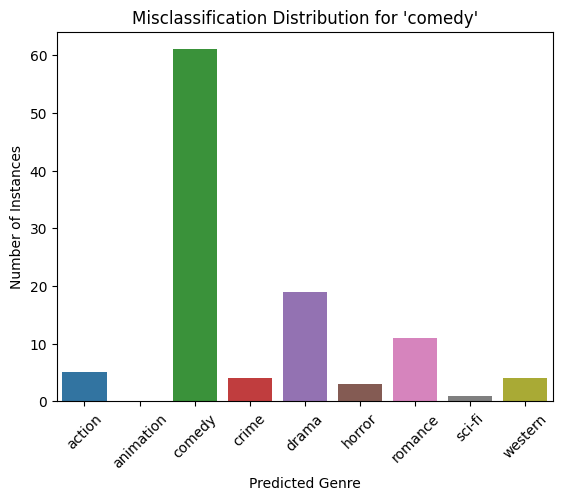

In [18]:
# Get indices where true genre is 'comedy'
comedy_indices = np.where(true_classes == 'comedy')[0]

# Among these, find indices where the prediction is not 'comedy'
misclassified_indices = comedy_indices[predicted_classes[comedy_indices] != 'comedy']

print(f"Total 'comedy' instances: {len(comedy_indices)}")
print(f"Misclassified 'comedy' instances: {len(misclassified_indices)}")

# Get the predicted genres for the misclassified 'comedy' instances
misclassified_predicted_genres = predicted_classes[misclassified_indices]

# Count the occurrences of each predicted genre
from collections import Counter

genre_counts = Counter(misclassified_predicted_genres)

print("\nGenres predicted instead of 'comedy':")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

# Get the misclassified examples from the test dataset
# Note: Ensure that 'test_data' is accessible here; if not, you may need to adjust the code
misclassified_data = test_data.reset_index(drop=True).iloc[misclassified_indices]

# Add the predicted genres to the DataFrame
misclassified_data = misclassified_data.copy()
misclassified_data['Predicted_Genre'] = predicted_classes[misclassified_indices]

# Display a few examples
print("\nExamples of misclassified 'comedy' movies:")
for idx, row in misclassified_data.head(5).iterrows():
    print(f"Title: {row['Title']}")
    print(f"Director: {row['Director']}")
    print(f"Plot: {row['Plot']}")
    print(f"True Genre: {row['Genre']}")
    print(f"Predicted Genre: {row['Predicted_Genre']}")
    print("-" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset confusion matrix for 'comedy'
comedy_row_index = list(label_encoder.classes_).index('comedy')
cm_comedy = cm[comedy_row_index, :]

# Plot the misclassification distribution for 'comedy'
plt.figure()
sns.barplot(x=label_encoder.classes_, y=cm_comedy)
plt.title("Misclassification Distribution for 'comedy'")
plt.xlabel("Predicted Genre")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.savefig('misclassification_distribution_comedy.png', bbox_inches='tight')
plt.show()

### c. Analysis of Animation misclassification

Total 'animation' instances: 55
Misclassified 'animation' instances: 11

Genres predicted instead of 'animation':
drama: 2
sci-fi: 4
western: 2
action: 3

Examples of misclassified 'animation' movies:
Title:  Waking Life
Director: richard linklater
Plot: waking life unnamed3 young man living ethereal existence lacks transitions everyday events eventually progresses toward existential crisis film observes quietly later participates actively philosophical discussions involving charactersranging quirky scholars artists everyday restaurantgoers friendsabout issues metaphysics free social philosophy meaning life scenes even include protagonists presence rather focus random isolated person group people couple engaging topics disembodied perspective along way film touches also upon existentialism situationist politics posthumanity film theory andre bazin lucid dreaming makes references various celebrated intellectual literary figures name gradually protagonist begins realize living perpetual 

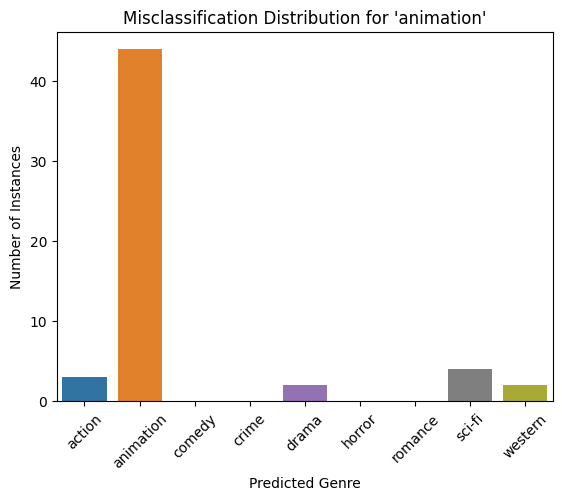

In [19]:
# Get indices where true genre is 'animation'
animation_indices = np.where(true_classes == 'animation')[0]

# Among these, find indices where the prediction is not 'animation'
misclassified_indices = animation_indices[predicted_classes[animation_indices] != 'animation']

print(f"Total 'animation' instances: {len(animation_indices)}")
print(f"Misclassified 'animation' instances: {len(misclassified_indices)}")

# Get the predicted genres for the misclassified 'animation' instances
misclassified_predicted_genres = predicted_classes[misclassified_indices]

# Count the occurrences of each predicted genre
from collections import Counter

genre_counts = Counter(misclassified_predicted_genres)

print("\nGenres predicted instead of 'animation':")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

# Get the misclassified examples from the test dataset
# Note: Ensure that 'test_data' is accessible here; if not, you may need to adjust the code
misclassified_data = test_data.reset_index(drop=True).iloc[misclassified_indices]

# Add the predicted genres to the DataFrame
misclassified_data = misclassified_data.copy()
misclassified_data['Predicted_Genre'] = predicted_classes[misclassified_indices]

# Display a few examples
print("\nExamples of misclassified 'animation' movies:")
for idx, row in misclassified_data.head(5).iterrows():
    print(f"Title: {row['Title']}")
    print(f"Director: {row['Director']}")
    print(f"Plot: {row['Plot']}")
    print(f"True Genre: {row['Genre']}")
    print(f"Predicted Genre: {row['Predicted_Genre']}")
    print("-" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset confusion matrix for 'animation'
animation_row_index = list(label_encoder.classes_).index('animation')
cm_animation = cm[animation_row_index, :]

# Plot the misclassification distribution for 'animation'
plt.figure()
sns.barplot(x=label_encoder.classes_, y=cm_animation)
plt.title("Misclassification Distribution for 'animation'")
plt.xlabel("Predicted Genre")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.savefig('misclassification_distribution_animation.png', bbox_inches='tight')
plt.show()

### d. Analysis of Action misclassification

Total 'action' instances: 103
Misclassified 'action' instances: 25

Genres predicted instead of 'action':
comedy: 2
romance: 4
crime: 4
drama: 7
animation: 1
western: 3
sci-fi: 3
horror: 1

Examples of misclassified 'action' movies:
Title: Namma Basava
Director: veera shankar
Plot: basava puneeth rajkumar runs gym centre lives brother avinash sudharani wife avinash treat son permanently opposed competitors brother start seeking girl bride opines select future bride selects gowri daughter auditor working pampathy pampathys younger brother home minister pampathys son vagabond womanizer gain approval basava makes every effort get green signal engagement fixed vagabond son pampathy supported gowris peppy naughty grandmother lakshmidevi basava rises autocratic behaviour pampathy challenges public wins thereby also winning heart hand gowri
True Genre: action
Predicted Genre: comedy
--------------------------------------------------------------------------------
Title: Kanteerava
Director: tu

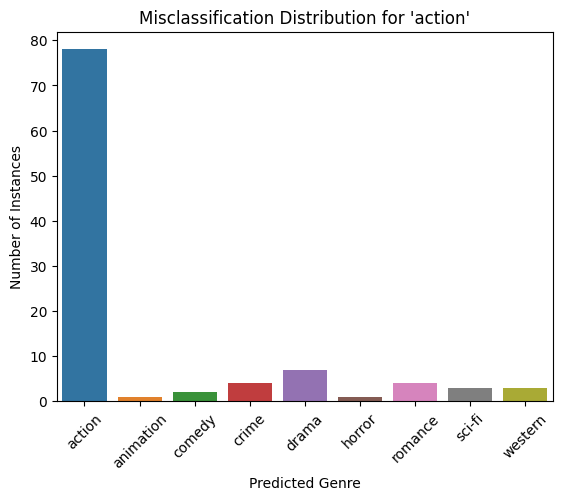

In [20]:
# Get indices where true genre is 'action'
action_indices = np.where(true_classes == 'action')[0]

# Among these, find indices where the prediction is not 'action'
misclassified_indices = action_indices[predicted_classes[action_indices] != 'action']

print(f"Total 'action' instances: {len(action_indices)}")
print(f"Misclassified 'action' instances: {len(misclassified_indices)}")

# Get the predicted genres for the misclassified 'action' instances
misclassified_predicted_genres = predicted_classes[misclassified_indices]

# Count the occurrences of each predicted genre
from collections import Counter

genre_counts = Counter(misclassified_predicted_genres)

print("\nGenres predicted instead of 'action':")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

# Get the misclassified examples from the test dataset
# Note: Ensure that 'test_data' is accessible here; if not, you may need to adjust the code
misclassified_data = test_data.reset_index(drop=True).iloc[misclassified_indices]

# Add the predicted genres to the DataFrame
misclassified_data = misclassified_data.copy()
misclassified_data['Predicted_Genre'] = predicted_classes[misclassified_indices]

# Display a few examples
print("\nExamples of misclassified 'action' movies:")
for idx, row in misclassified_data.head(5).iterrows():
    print(f"Title: {row['Title']}")
    print(f"Director: {row['Director']}")
    print(f"Plot: {row['Plot']}")
    print(f"True Genre: {row['Genre']}")
    print(f"Predicted Genre: {row['Predicted_Genre']}")
    print("-" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset confusion matrix for 'action'
action_row_index = list(label_encoder.classes_).index('action')
cm_action = cm[action_row_index, :]

# Plot the misclassification distribution for 'action'
plt.figure()
sns.barplot(x=label_encoder.classes_, y=cm_action)
plt.title("Misclassification Distribution for 'action'")
plt.xlabel("Predicted Genre")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.savefig('misclassification_distribution_action.png', bbox_inches='tight')
plt.show()

### e. Analysis of Crime misclassification

Total 'crime' instances: 50
Misclassified 'crime' instances: 17

Genres predicted instead of 'crime':
horror: 3
action: 4
drama: 6
western: 2
comedy: 2

Examples of misclassified 'crime' movies:
Title: Urge to Kill
Director: vernon sewell
Plot: making way home cinema one night particularly grey drab town young woman murdered unusually brutal sadistic manner local suspicion immediately falls hughie knapp strangely behaved bright local youth habit wandering aimlessly around town hours randomly collecting stray bits pieces particular fondness broken glass unfortunately hughie happens one weapons used fatal attack hughie lives lodging house run aunt dunning along selection boarders including kindly elderly gent penchant biblebashing wilfrid brambell smoothtalking ladies man howard pays hughie questioned police superintendent allen barr releases firm evidence days later another girl killed town locals make minds hughie responsible launch witchhunt believing police failing job properly start

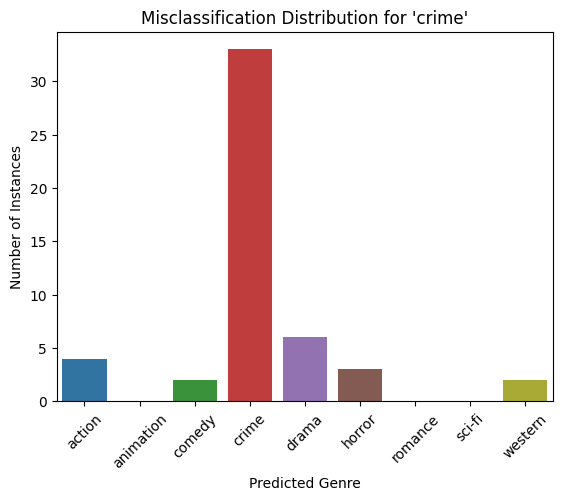

In [21]:
# Get indices where true genre is 'crime'
crime_indices = np.where(true_classes == 'crime')[0]

# Among these, find indices where the prediction is not 'crime'
misclassified_indices = crime_indices[predicted_classes[crime_indices] != 'crime']

print(f"Total 'crime' instances: {len(crime_indices)}")
print(f"Misclassified 'crime' instances: {len(misclassified_indices)}")

# Get the predicted genres for the misclassified 'crime' instances
misclassified_predicted_genres = predicted_classes[misclassified_indices]

# Count the occurrences of each predicted genre
from collections import Counter

genre_counts = Counter(misclassified_predicted_genres)

print("\nGenres predicted instead of 'crime':")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

# Get the misclassified examples from the test dataset
# Note: Ensure that 'test_data' is accessible here; if not, you may need to adjust the code
misclassified_data = test_data.reset_index(drop=True).iloc[misclassified_indices]

# Add the predicted genres to the DataFrame
misclassified_data = misclassified_data.copy()
misclassified_data['Predicted_Genre'] = predicted_classes[misclassified_indices]

# Display a few examples
print("\nExamples of misclassified 'crime' movies:")
for idx, row in misclassified_data.head(5).iterrows():
    print(f"Title: {row['Title']}")
    print(f"Director: {row['Director']}")
    print(f"Plot: {row['Plot']}")
    print(f"True Genre: {row['Genre']}")
    print(f"Predicted Genre: {row['Predicted_Genre']}")
    print("-" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset confusion matrix for 'crime'
crime_row_index = list(label_encoder.classes_).index('crime')
cm_crime = cm[crime_row_index, :]

# Plot the misclassification distribution for 'crime'
plt.figure()
sns.barplot(x=label_encoder.classes_, y=cm_crime)
plt.title("Misclassification Distribution for 'crime'")
plt.xlabel("Predicted Genre")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.savefig('misclassification_distribution_crime.png', bbox_inches='tight')
plt.show()

### f. Analysis of Drama misclassification

Total 'drama' instances: 168
Misclassified 'drama' instances: 51

Genres predicted instead of 'drama':
action: 18
horror: 9
romance: 5
comedy: 7
western: 1
sci-fi: 1
animation: 2
crime: 8

Examples of misclassified 'drama' movies:
Title: Rover, TheThe Rover
Director: david michod
Plot: ten years global economic collapse caused worldwide turmoil australian outback lawless wasteland crime poverty common small military units patrol outback attempting maintain little law order left robbery gone wrong archie david field caleb tawanda manyimo henry scoot mcnairy flee leaving behind henrys injured brother rey robert pattinson driving away archie mocks rey henry attacks causing caleb crash truck riding cannot manoeuvre truck debris abandon archie steals car belonging mysterious loner eric guy pearce eric manages free truck follows brief chase archie stops eric confronts eric tries attack archie henry knocks unconscious shotgun eric wakes drives truck town wanders several establishments asking 

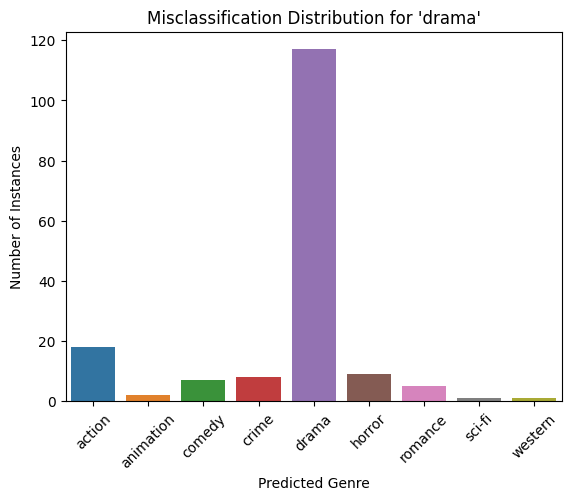

In [22]:
# Get indices where true genre is 'drama'
drama_indices = np.where(true_classes == 'drama')[0]

# Among these, find indices where the prediction is not 'drama'
misclassified_indices = drama_indices[predicted_classes[drama_indices] != 'drama']

print(f"Total 'drama' instances: {len(drama_indices)}")
print(f"Misclassified 'drama' instances: {len(misclassified_indices)}")

# Get the predicted genres for the misclassified 'drama' instances
misclassified_predicted_genres = predicted_classes[misclassified_indices]

# Count the occurrences of each predicted genre
from collections import Counter

genre_counts = Counter(misclassified_predicted_genres)

print("\nGenres predicted instead of 'drama':")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

# Get the misclassified examples from the test dataset
# Note: Ensure that 'test_data' is accessible here; if not, you may need to adjust the code
misclassified_data = test_data.reset_index(drop=True).iloc[misclassified_indices]

# Add the predicted genres to the DataFrame
misclassified_data = misclassified_data.copy()
misclassified_data['Predicted_Genre'] = predicted_classes[misclassified_indices]

# Display a few examples
print("\nExamples of misclassified 'drama' movies:")
for idx, row in misclassified_data.head(5).iterrows():
    print(f"Title: {row['Title']}")
    print(f"Director: {row['Director']}")
    print(f"Plot: {row['Plot']}")
    print(f"True Genre: {row['Genre']}")
    print(f"Predicted Genre: {row['Predicted_Genre']}")
    print("-" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset confusion matrix for 'drama'
drama_row_index = list(label_encoder.classes_).index('drama')
cm_drama = cm[drama_row_index, :]

# Plot the misclassification distribution for 'drama'
plt.figure()
sns.barplot(x=label_encoder.classes_, y=cm_drama)
plt.title("Misclassification Distribution for 'drama'")
plt.xlabel("Predicted Genre")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.savefig('misclassification_distribution_drama.png', bbox_inches='tight')
plt.show()

### g. Analysis of Horror misclassification

Total 'horror' instances: 120
Misclassified 'horror' instances: 11

Genres predicted instead of 'horror':
action: 2
comedy: 2
drama: 3
romance: 1
crime: 1
sci-fi: 2

Examples of misclassified 'horror' movies:
Title: Holocaust 2000
Director: alberto de martino
Plot: despite doomsday warnings throngs locals wealthy industrialist robert caine kirk douglas makes controversial decision build nuclear power plant near sacred cave middle east caine reap benefits latest bid global domination discovers son angel simon ward antichrist planning use fathers project trigger end world
True Genre: horror
Predicted Genre: action
--------------------------------------------------------------------------------
Title: Rebel High
Director: john fasano
Plot: film starts high school students return spring break also new principal edwin swimper arrives last principal died stress school gave teachers teaching empty classes constant gang war hallway male teachers wearing various armors swimper decides implement

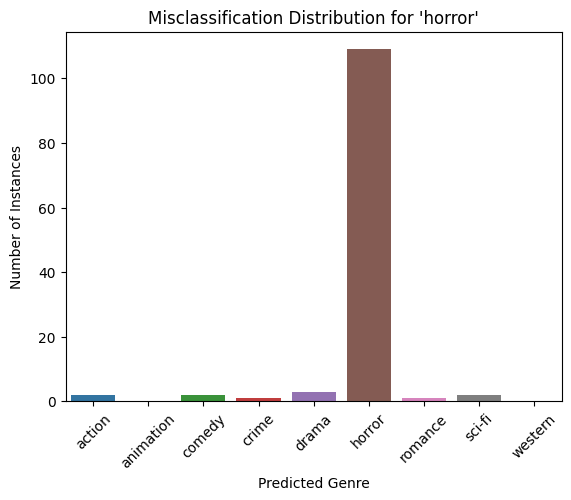

In [23]:
# Get indices where true genre is 'horror'
horror_indices = np.where(true_classes == 'horror')[0]

# Among these, find indices where the prediction is not 'horror'
misclassified_indices = horror_indices[predicted_classes[horror_indices] != 'horror']

print(f"Total 'horror' instances: {len(horror_indices)}")
print(f"Misclassified 'horror' instances: {len(misclassified_indices)}")

# Get the predicted genres for the misclassified 'horror' instances
misclassified_predicted_genres = predicted_classes[misclassified_indices]

# Count the occurrences of each predicted genre
from collections import Counter

genre_counts = Counter(misclassified_predicted_genres)

print("\nGenres predicted instead of 'horror':")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

# Get the misclassified examples from the test dataset
# Note: Ensure that 'test_data' is accessible here; if not, you may need to adjust the code
misclassified_data = test_data.reset_index(drop=True).iloc[misclassified_indices]

# Add the predicted genres to the DataFrame
misclassified_data = misclassified_data.copy()
misclassified_data['Predicted_Genre'] = predicted_classes[misclassified_indices]

# Display a few examples
print("\nExamples of misclassified 'horror' movies:")
for idx, row in misclassified_data.head(5).iterrows():
    print(f"Title: {row['Title']}")
    print(f"Director: {row['Director']}")
    print(f"Plot: {row['Plot']}")
    print(f"True Genre: {row['Genre']}")
    print(f"Predicted Genre: {row['Predicted_Genre']}")
    print("-" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset confusion matrix for 'horror'
horror_row_index = list(label_encoder.classes_).index('horror')
cm_horror = cm[horror_row_index, :]

# Plot the misclassification distribution for 'horror'
plt.figure()
sns.barplot(x=label_encoder.classes_, y=cm_horror)
plt.title("Misclassification Distribution for 'horror'")
plt.xlabel("Predicted Genre")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.savefig('misclassification_distribution_horror.png', bbox_inches='tight')
plt.show()

### h. Analysis of Sci-Fi misclassification

Total 'sci-fi' instances: 18
Misclassified 'sci-fi' instances: 5

Genres predicted instead of 'sci-fi':
action: 2
horror: 3

Examples of misclassified 'sci-fi' movies:
Title: Dimension 5
Director: franklin adreon
Plot: justin power hunter agent espionage inc returns mission used timetravel belt steal secret plans told superior cane donald woods teamed chinese agent combat asian crime ring dragon headed crime lord big buddha sakata sister agency discovered dragon plans destroy los angeles united states forces withdrawn east asia aware dragon primitive hydrogen bomb way deliver espionage inc plans interrogate captured agent chang gerald jann chang brought hong kong two agentssato robert ito george robert phillipsso might learn dragon plans chang insists dragon see never talk assassination attempt occurs immediately though george killed chang survives female agent shoots assassin dart informed incident power goes ontario airport uses timetravel device preview assassination man cowboy suit

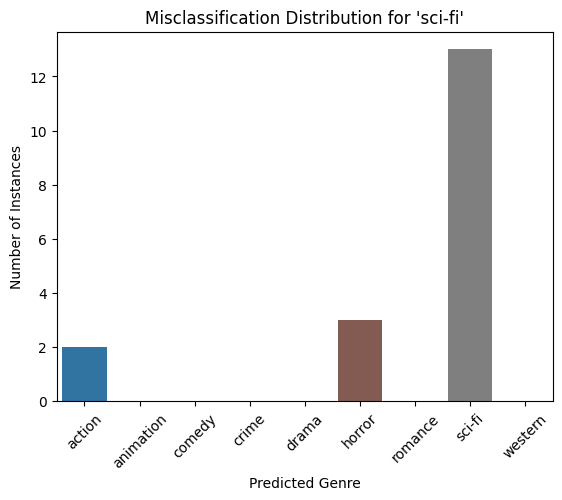

In [24]:
# Get indices where true genre is 'sci-fi'
sci_fi_indices = np.where(true_classes == 'sci-fi')[0]

# Among these, find indices where the prediction is not 'sci-fi'
misclassified_indices = sci_fi_indices[predicted_classes[sci_fi_indices] != 'sci-fi']

print(f"Total 'sci-fi' instances: {len(sci_fi_indices)}")
print(f"Misclassified 'sci-fi' instances: {len(misclassified_indices)}")

# Get the predicted genres for the misclassified 'sci-fi' instances
misclassified_predicted_genres = predicted_classes[misclassified_indices]

# Count the occurrences of each predicted genre
from collections import Counter

genre_counts = Counter(misclassified_predicted_genres)

print("\nGenres predicted instead of 'sci-fi':")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

# Get the misclassified examples from the test dataset
# Note: Ensure that 'test_data' is accessible here; if not, you may need to adjust the code
misclassified_data = test_data.reset_index(drop=True).iloc[misclassified_indices]

# Add the predicted genres to the DataFrame
misclassified_data = misclassified_data.copy()
misclassified_data['Predicted_Genre'] = predicted_classes[misclassified_indices]

# Display a few examples
print("\nExamples of misclassified 'sci-fi' movies:")
for idx, row in misclassified_data.head(5).iterrows():
    print(f"Title: {row['Title']}")
    print(f"Director: {row['Director']}")
    print(f"Plot: {row['Plot']}")
    print(f"True Genre: {row['Genre']}")
    print(f"Predicted Genre: {row['Predicted_Genre']}")
    print("-" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset confusion matrix for 'sci-fi'
sci_fi_row_index = list(label_encoder.classes_).index('sci-fi')
cm_sci_fi = cm[sci_fi_row_index, :]

# Plot the misclassification distribution for 'sci-fi'
plt.figure()
sns.barplot(x=label_encoder.classes_, y=cm_sci_fi)
plt.title("Misclassification Distribution for 'sci-fi'")
plt.xlabel("Predicted Genre")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.savefig('misclassification_distribution_sci_fi.png', bbox_inches='tight')
plt.show()

### i. Analysis of Western misclassification

Total 'western' instances: 98
Misclassified 'western' instances: 2

Genres predicted instead of 'western':
horror: 1
crime: 1

Examples of misclassified 'western' movies:
Title: The Proposition
Director: john hillcoat
Plot: set australian outback 1880s movie follows series events following horrific rape murder hopkins family likely committed infamous burns brothers gang film opens remote building violent gunfight police charlie burns guy pearce gang ends deaths gang members except charlie younger brother mikey captain stanley ray winstone makes proposition charlie feebleminded mikey go free crimes committed charlie kills older brother arthur danny huston arthur mercurial psychopath vicious aboriginal tribes refer dog man police aborigines refuse go near camp captain stanley states intention civilize harsh australian wilderness bringing arthur justice using mikey leverage charlie nine days find kill arthur else mikey hanged gallows christmas day captain stanleys motivations taming austr

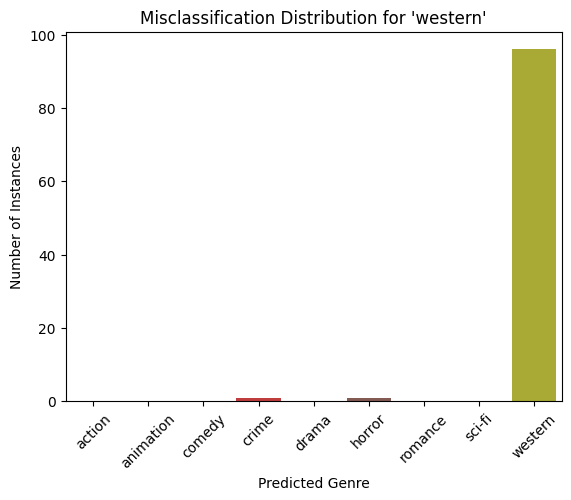

In [25]:
# Get indices where true genre is 'western'
western_indices = np.where(true_classes == 'western')[0]

# Among these, find indices where the prediction is not 'western'
misclassified_indices = western_indices[predicted_classes[western_indices] != 'western']

print(f"Total 'western' instances: {len(western_indices)}")
print(f"Misclassified 'western' instances: {len(misclassified_indices)}")

# Get the predicted genres for the misclassified 'western' instances
misclassified_predicted_genres = predicted_classes[misclassified_indices]

# Count the occurrences of each predicted genre
from collections import Counter

genre_counts = Counter(misclassified_predicted_genres)

print("\nGenres predicted instead of 'western':")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

# Get the misclassified examples from the test dataset
# Note: Ensure that 'test_data' is accessible here; if not, you may need to adjust the code
misclassified_data = test_data.reset_index(drop=True).iloc[misclassified_indices]

# Add the predicted genres to the DataFrame
misclassified_data = misclassified_data.copy()
misclassified_data['Predicted_Genre'] = predicted_classes[misclassified_indices]

# Display a few examples
print("\nExamples of misclassified 'western' movies:")
for idx, row in misclassified_data.head(5).iterrows():
    print(f"Title: {row['Title']}")
    print(f"Director: {row['Director']}")
    print(f"Plot: {row['Plot']}")
    print(f"True Genre: {row['Genre']}")
    print(f"Predicted Genre: {row['Predicted_Genre']}")
    print("-" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

# Create a subset confusion matrix for 'western'
western_row_index = list(label_encoder.classes_).index('western')
cm_western = cm[western_row_index, :]

# Plot the misclassification distribution for 'western'
plt.figure()
sns.barplot(x=label_encoder.classes_, y=cm_western)
plt.title("Misclassification Distribution for 'western'")
plt.xlabel("Predicted Genre")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.savefig('misclassification_distribution_western.png', bbox_inches='tight')
plt.show()